## Single-cell analysis tutorial 1: 

# Processing scRNA-seq data with Seurat

*Prepared by Sara Aibar, based on a previous tutorial by Zeynep Kalender Atak* 

---

In this notebook we will use [Seurat](http://satijalab.org/seurat/) to analyze a single-cell RNA-seq dataset (find cell populations and marker genes). 

Seurat is one of the most broadly used tools to do this types of analysis. For a general overview on how to analyze single-cell RNA-seq data, **we recommend reading these papers**:

* [Identifying cell populations with scRNASeq](https://www.sciencedirect.com/science/article/pii/S0098299717300493) (An easy-to-read review on single-cell sequencing technologies, methodologies and computational pipelines)

* [Current best practices in single‐cell RNA‐seq analysis](https://doi.org/10.15252/msb.20188746) 

You also can check these additional resources and **alternative analysis methods** and tutorials: 

* [ASAP](https://asap.epfl.ch): Web-based platform ("Automated Single-cell Analysis Pipeline")
* [scanpy](https://scanpy.readthedocs.io/en/stable/): For analyses in Python
* [scRNA tools](https://www.scrna-tools.org) and [Awesome single-cell repository](https://github.com/linnarsson-lab/awesome-single-cell): Catalogues of tools for analysing single-cell RNA sequencing data. 
* [Seurat](https://satijalab.org/seurat/articles/get_started.html) website: They keep expanding the tool to support new types of analyses and data formats (e.g. multiome, spatial...). Most of these are quite advanced analyses, but can be very useful! Some that are worth special emphasis are [Harmony](https://portals.broadinstitute.org/harmony/SeuratV3.html) for batch correction, and the tutorials for integration of datasets to reference atlases.
* [Cell type annotation](https://www.10xgenomics.com/resources/analysis-guides/web-resources-for-cell-type-annotation) resources (also, check this paper: [paper](https://www.nature.com/articles/s41596-021-00534-0)).

#### Outline

For the single-cell part of the course we provide two main tutorials, both analyzing a public Breast Cancer dataset: 

1. **Processing scRNA-seq data with Seurat** *(This notebook)* 

2. **Processing spatial transcriptomics data with Seurat** 

In addition, we provide two extra (optional) tutorials:
3. *Processing scRNA-seq data with Seurat (MCF7 case study):* This notebook shows an analisiss of an 'in-house'  dataset, to illustrate some of the issues you might encounter on a dataset without a pre-selection of good cells (such as in publications), including some trials/examples for batch correction.

4. *Inferring gene regulatory networks (GRNs) with SCENIC* 


With these tutorials you will get familiar with single-cell RNA-seq data analysis and be able to perform a standard analysis (normalization, clustering and marker gene discovery; and optionally, GRN inference or spatial annotation).


#### Problems? 

When you are doing your own analysis, you will run into problems. In that case: 

* **Read the error message**: most of the time they are self-explanatory
* Google that error message: if it's not clear to you what the problem is, just Google it; scRNA-seq community is very active (e.g. on BioStars or on stackoverflow) 
* Check the **help page of the function** you're using (e.g. `?VlnPlot`) 
* Find and follow the package **tutorials**. Seurat also has quite useful cheatsheets (https://satijalab.org/seurat/essential_commands.html) 
* Come to the feedback session!


#### Finding a new dataset

If you want to make a project with scRNA-seq data, we recommend to look for **publications** analyzing this type of data (e.g. ). In the paper's *Data availability* section, they will indicate where they have deposited the data (e.g. [GEO](https://www.ncbi.nlm.nih.gov/geo/), or an alternative repository).

In addition, you can also look for atlases and in single-cell specific repositories such as [UCSC cell browser](https://cells.ucsc.edu/), [Human cell atlas](https://www.humancellatlas.org/), [Single-cell Portal](https://singlecell.broadinstitute.org), ...; or in [10X Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets) website, where they also provide a few good-quality datasets.

In order find an interesting (and easy) dataset to analyze, you should look for these characteristics:
* Enough, but not too many cells. Around **1000-5000 cells** is a reasonable size (under 500 there might not be enough resolution, over 10k it might take too long to run the scripts). If you would like to analyze a bigger dataset for your project, then we would recommend you to sub-sample the cells (for example, choosing 5000 random cells after downloading the counts matrix, as we are doing in this example).
* Several cell types or states are present in the dataset (to make the analysis interesting).
* **Counts matrix** available. In the single-cell tutorials we always start from a counts matrix or CellRanger output). The previous steps of mapping, etc... are usually done with dedicated tools (such as  CellRanger for 10X data). 


### Prepare your workspace

Make sure set your working directory to a place where you have enough space to save large data.

In R, you do that with the `setwd` command (analogous `cd` in bash).

In [ ]:
setwd(path.expand("~/data/jupyternotebooks/")) # "~" is your home directory

Create a folder for this session. You can do that with `dir.create` command in R.

In [ ]:
dir.create("scRNAseq")

If the directory is already there, it won't create it (again) and will give a warning.

In [ ]:
setwd("scRNAseq")

You can check which directory you are in using the comman `getwd` (analogous to the `pwd` command of bash).

In [ ]:
getwd()

After setting up your working directory, you can start.

### Load libraries
Load some R packages that help you to analyze single cell RNA-Seq data.

In [ ]:
options(stringsAsFactors=FALSE)

library(Seurat)
library(dplyr)
library(Matrix)
library(SCopeLoomR)
library(IRdisplay)
library(plyr)
library(patchwork)

### Select/Download your data

In this tutorial we will analyze the Breast Cancer dataset from ***A single-cell and spatially resolved atlas of human breast cancers*** ([Wu et al 2021](https://www.nature.com/articles/s41588-021-00911-1)).


As in most papers, the **"Data availability" section** contains the list of datasets and where you can download them from. e.g.:


> All **processed scRNA-seq data** are available for in-browser exploration and download through the Broad Institute Single Cell portal at https://singlecell.broadinstitute.org/single_cell/study/SCP1039. 
> Processed scRNA-seq data from this study are also available through the Gene Expression Omnibus under accession number GSE176078. 
> **Raw scRNA-seq data** from this study have been deposited with the European Genome-phenome Archive, which is hosted by the European Bioinformatics Institute and Centre for Genomic Regulation under accession no. EGAS00001005173. 
> All **spatially resolved transcriptomics** data from this study are available from the Zenodo data repository (https://doi.org/10.5281/zenodo.4739739). 
> Spatially resolved transcriptomics data from Andersson et al.56 can be downloaded from the Zenodo data repository (https://doi.org/10.5281/zenodo.3957257).

For this paper, we have downloaded and subset the *Cell Ranger files* for you `Allcells_raw_count_out.zip` from [the single-cell portal](https://singlecell.broadinstitute.org/single_cell/study/SCP1039/a-single-cell-and-spatially-resolved-atlas-of-human-breast-cancers#study-download), and subset and stored them in `/mnt/storage/data/scRNA_BreastCancer/CellRanger_out`.


### Which format to choose? 

Some papers provide the dataset in several alternative formats.

For this tutorial will use the "**Cell Ranger** output" because it is the most standard output from an experiment. This way you have an example that you could replicate in a real life situation. 

**CellRanger** is the software tool provided by 10X genomics for their single-cell datasets. It maps the reads to the genome and splits them by barcode. In addition they provide some reports including a preliminary clustering and QC metrics. It provides three main output files:

- `matrix.mtx.gz` Contains the **expression** values (counts) for each cell in each gene.
- `barcodes.tsv.gz` List of barcodes included in the matrix. These usually refer to **cells**.
- `features.tsv.gz` List of "features" included in the matrix. These are usually **genes**, in case of single-cell RNA-seq data, but could also be other types of 'features', such as peaks in scATAC-seq, etc...


Most single-cell analysis tools can read these three files, and convert them into a **formatted expression matrix** . In many publications, this formatted matrix is also available to download. For example, in GEO, these matrices are usually provided as "processed data" (under `Supplementary file` section). 

The way to use both matrices is very similar, you might just need to slightly adapt the function to read it (i.e. section *Load the raw data*). 


### Downloading the data

You need to get the data from the webistes to the Jupyter hub. 

One way would be to download the file to your computer and transfer it using BitWise. Another option is to download the file directly to the teaching server using the command line. 

In `bash` you can do that using `wget` command (you just type wget and the **ftp** link to the file). 

In this Jupyter notebook, you are in an `R` kernel (i.e. running `R`, not `bash`), so you can use the `system` command from `R` to run `bash` commands.

e.g. An example of code to download a and read a matrix could be:

```
system("wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE176nnn/GSE176078/suppl/GSE176078%5FWu%5Fetal%5F2021%5FBRCA%5FscRNASeq%2Etar%2Egz")
exprMatrix <- data.table::fread("GSE176078_Wu_etal_2021_BRCA_scRNASeq.tar.gz")
```

In [ ]:
# We have stored the CellRanger output, as well as the cell annotation in this folder:
dir('/mnt/storage/data/scRNA_BreastCancer/')

In [ ]:
dir('/mnt/storage/data/scRNA_BreastCancer/CellRanger_out/')

#### Optional: Subset dataset

To run the tutorials and your project in a reasonable time, we suggest a dataset size somewhere betwen 1k and 10k cells (these are standard sizes for a single 10X run). 

The dataset in this example contains 100k cells (i.e. it is composed of multiple samples), so we have subset 5k cells to make sure we have time to run the analyses during the class.

This is the code we used to subset the dataset (i.e. you can adapt it to subset your own dataset if needed):

- `FullDataset`: Contains the whole files (downloaded from the web) 

- `CellRanger_out`: Contains the subset of 5k cells (also in CellRanger format, so we can use the same code in the tutorial)

> (You don't need to run this section for this tutorial)

In [ ]:
dir('FullDataset')

In [ ]:
# Load whole dataset
expression_matrix <- Read10X(
  data.dir='FullDataset/',
  unique.features = TRUE,
  strip.suffix = FALSE
)
seurat_object = CreateSeuratObject(counts = expression_matrix)

In [ ]:
# select 5k random cells from the dataset
set.seed(123) # Makes the random selection reproducible
numCells <- dim(seurat_object_full)[2] # Number of cells in the object
cellsSubset <- sort(sample(1:numCells, 5000))
length(cellsSubset)

In [ ]:
# Subset dataset: Now it contains 5k cells
seurat_object = seurat_object[,cellsSubset]
seurat_object

In [ ]:
# Export in CellRanger format 
suppressPackageStartupMessages(library(DropletUtils))
exprMat = seurat_object[['RNA']]@counts

write10xCounts(x=exprMat, path = 'CellRanger_out')

### Load the raw data (expression matrix)

In [ ]:
# Check the content of the path: 
dir('/mnt/storage/data/scRNA_BreastCancer/CellRanger_out/')

In [ ]:
# Read the file and format as expression matrix
expression_matrix <- Read10X(
  data.dir='/mnt/storage/data/scRNA_BreastCancer/CellRanger_out/',
  unique.features = TRUE,
  strip.suffix = FALSE
)
dim(expression_matrix)

These tables are typically quite big. In this case, there are 29733 genes (rows), and 5000 cells (columns).

So... do not show it all at once, instead inpect it by pieces.

In [ ]:
#inspect the top left corner of the expression matrix
expression_matrix[1:50,1:2]

You may have noticed that the columns contain a 'barcode' with prefix or sufix. 
These prefix/sufixes normally match the sample. They are used to make sure the barcodes stay unique after merging different samples into a single matrix.

### Create a Seurat object

A *Seurat object* will contain all data related to this analysis. This function will create the object from an expression matrix. Since the expression matrix can contain (almost) empty rows or columns, we can especify to load only those with a minimum number of counts.  

These requirements can be adjusted based on the dataset. `min.features` is usually set somewere between 200 and 1000. Don't go too high, or you might start keeping mostly doublets!

In this case, we keep genes that are expressed in at least 20 cells, and cells that express at least 200 genes. We can filter them further later on. Notice that in this case we keep all 5000 cells. Probably because the dataset is already filtered.

In [ ]:
seurat_object = CreateSeuratObject(counts = expression_matrix, min.cells = 20, min.features = 200)
seurat_object # Shows a summary of the object

#### Add meta data

In most analyses, there is also **information about the samples**. For example, which patient they come from, what is the tissue/disease, any treatment they might have been put through, etc.... 

This information is important for the analysis (to do comparisons, check quality, and possible batch effects, ...), so it is usually added to the SeuratObject as `metadata`. 

> In addition, for public datasets we usually have the clusters or "cell type annotation" that they assigned in the publications.


The metadata for this dataset (also downloaded from [the single-cell portal](https://singlecell.broadinstitute.org/single_cell/study/SCP1039/a-single-cell-and-spatially-resolved-atlas-of-human-breast-cancers#study-download) is also available in `/mnt/storage/data/scRNA_BreastCancer/`.

In [ ]:
cellMetadata <- read.delim('/mnt/storage/data/scRNA_BreastCancer/Whole_miniatlas_meta.csv', sep=',')
head(cellMetadata)

In [ ]:
dim(cellMetadata)

Let's subset the columns that we want to keep, and select the cells that we have in the dataset (also making sure they are in the same order): 

In [ ]:
# Use cells as row names (easier subset)
rownames(cellMetadata) <- cellMetadata$NAME

# Select relevant annotations
cellMetadata <- cellMetadata[,c('Patient', 'celltype_major', 'celltype_minor', 'celltype_subset')]

# Select cells in the seurat object
cellMetadata <- cellMetadata[Cells(seurat_object),]
dim(cellMetadata)

In [ ]:
head(cellMetadata)

We can now add the cell annotation to the seurat_object:

In [ ]:
seurat_object <- AddMetaData(seurat_object, metadata = cellMetadata)

Confirm it is added/preview:

> `seurat_object[[]]` is an alias to `seurat_object@meta.data`

In [ ]:
head(seurat_object[[]])

In this dataset each sample/batch (stored in `orig.ident`) corresponds to a patient:

In [ ]:
all(seurat_object[['orig.ident']] == seurat_object[['Patient']])

In [ ]:
# Number of cells by batch:
cbind(table(seurat_object[['orig.ident']]))

The Seurat object is now ready to start the analysis, you can save it:

In [ ]:
save(seurat_object, file='seurat_object_breast_cancer.RData')


### Quality control & Filtering

While the `CreateSeuratObject` command imposes a basic minimum gene-cutoff, it does not filter out cells based on technical or biological parameters. 

The number of genes and **UMIs** (nFeature_RNA and nCount_RNA) are automatically calculated for every object by Seurat. We can visualize these values, and exclude cells with a **clear outlier number of genes**.

The filter values can by on the low side (i.e. bad quality cells and empty droplets), or high-side (cells with extremely high number of genes are likely doublets).

> When several cells are trapped into a single droplet, this is called a **doublet**. The presence of doublets is one of the sources of technical bias. There are specialized tools to look for them in the data (e.g. [Demuxlet/Freemuxet](https://github.com/statgen/popscle) or [Scrublet](https://github.com/swolock/scrublet)) feell free to add an doublet-filter at this step.

In [ ]:
options(repr.plot.width=20, repr.plot.height=6) # To set the figure size
VlnPlot(object = seurat_object, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

By default, Seurat plots the distributions grouped by batch (`Ident(seurat_object)` or `seurat_object[['orig.ident']]`). To see the global distribution, we can add an extra metadata column with the same value for all the cells: 

In [ ]:
seurat_object[['AllData']] <- 'AllData'

In [ ]:
options(repr.plot.width=20, repr.plot.height=6) # To set the figure size
VlnPlot(object = seurat_object, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2, group.by='AllData')

In [ ]:
# View values
summary(seurat_object@meta.data$nFeature_RNA)

In the plot with the numbers of UMIs (nCount_RNA), we can see whether there are outlier cells with a low or high number of UMIs, and remove them from the Seurat object.

`FeatureScatter` can also be used for identifying/checking cells with high number of genes or UMIs:

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)
FeatureScatter(object = seurat_object, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by='AllData')

Since this dataset comes from a publication, it is already quite clean. 
For the example purposes, we will still filter the cells a bit further (requiring a minimum of 1000 features, and maximum 5000). 

We will double-check how many cells we would remove by these filters before applything them:

In [ ]:
# Check number of cells that pass the filter:
subset(seurat_object, subset = nFeature_RNA >= 1000 & nCount_RNA <= 25000)

In [ ]:
# Perform the filtering (i.e. store the returned object)
seurat_object <- subset(seurat_object, subset = nFeature_RNA >= 1000 & nCount_RNA <= 25000)

In [ ]:
seurat_object

This cell-filter decreases the number of cells from 5000 to 2958.

Let's see the new distributions:

In [ ]:
options(repr.plot.width=20, repr.plot.height=6)
VlnPlot(object = seurat_object, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2, group.by='Patient')

We could also visualize these metrics in relation to covariates of our experimental design (in this case we only have the `Patient`). 

#### Filtering based on mitochondrial genes

It is also common practice to use **mitochondrial** gene counts for quality control. Typical filters require cells to have under 3-5%. 
However, depending on the protocol or biological question, sometimes it is OK to allow much higer values (i.e. up to 10% or 30%, for example if the biological question involves changes in mitochondrial metabolism, or if they are hard to get cell types!).

Citing from [Simple Single Cell](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics) workflows (Lun, McCarthy & Marioni, 2017):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

To this end, we first add the percentage of mitochondrial reads for each cell to the meta data:

In [ ]:
seurat_object[["percent.mt"]] <- PercentageFeatureSet(seurat_object, pattern = "^MT-")

In [ ]:
summary(seurat_object[["percent.mt"]])

In [ ]:
head(seurat_object[[]])

In [ ]:
options(repr.plot.width=20, repr.plot.height=6)
VlnPlot(seurat_object, features = c("percent.mt"))

In this case, the authors of the paper chose to keep cells with up to 20% of mitochondrial reads. This is on the high side, but since it is a cancer dataset, we will not filter further to avoid biasing towards healthy cells.

### Normalizing the data 

After removing unwanted cells from the dataset, the next step is to normalize the data. 

By default, Seurat employs a global-scaling normalization method "LogNormalize" that normalizes the gene expression measurements **for each cell by the total expression**, multiplies this by a scale factor (10,000 by default), and log-transforms the result.

In [ ]:
seurat_object <- NormalizeData(seurat_object)

Normalized values are stored in `seurat_object[["RNA"]]@data`, which can be accessed with the function `GetAssayData`:

In [ ]:
# seurat_object[["RNA"]]@data[1:5,1:5]
GetAssayData(seurat_object, slot="data")[1:5,1:5]

While the original counts matrix is stored in `seurat_object[["RNA"]]@counts`:

In [ ]:
# seurat_object[["RNA"]]@counts
GetAssayData(seurat_object, slot="counts")[1:5,1:5]

### Find variable genes

The vast majority of the genes in the dataset will contain little information, either because they did not change in the context of this experiment, or because they are very noisy. A common approach is to focus on the most variable genes in the dataset. Seurat does this with the `FindVariableGenes` function:

In [ ]:
seurat_object <- FindVariableFeatures(seurat_object)

By default, the 2000 most variable genes are selected for downstream analysis (shown in red).

This plot shows gene dispersion (variability) vs average expression:

In [ ]:
# plot variable features
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- VariableFeaturePlot(seurat_object)
LabelPoints(plot=plot1, points=VariableFeatures(seurat_object)[1:10], repel = TRUE)

### Scaling the data

Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. 

The ScaleData function:

 * Shifts the expression of **each gene**, so that the **mean expression** across cells is 0
 * Scales the expression of each gene, so that the **variance** across cells is 1.
 
This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate.

> Note: by default, the `ScaleData` function is applied only to the 2000 most variable genes that were calculated in the previous step. However, to display genes e.g. in a heatmap, they need to be scaled so that highly-expressed genes don’t dominate the heatmap. To make sure we don’t leave any genes out of the heatmap later, we are scaling all genes in the data set by adding the argument `features = allGenes` to the function call.

It is also possible to indicate some variables to regress-out. For example, to correct, or at least reducce, batch effects or technical biases. 

In general we recommend to do a first pass of the analysis without corrections, and if needed, to come back to this step (or create a new notebook) and compare the results by correcting for the given the variables. For example: `vars.to.regress = c('percent.mt', 'Patient')`

In [ ]:
allGenes <- rownames(seurat_object)
seurat_object <- ScaleData(seurat_object, features = allGenes)

The scaled counts are stored in `seurat_object[["RNA"]]@scale.data`:

In [ ]:
# seurat_object[["RNA"]]@scale.data[1:5,1:5]
GetAssayData(seurat_object, slot="scale.data")[1:5,1:5]

### Dimensionality reduction (PCA)

Next, we perform a principal component analysis (PCA) on the scaled data. 
PCA is a linear feature extraction technique that maps our high-dimensional expression data to a lower-dimensionality space in a way that the variance of the data in the low-dimensional representation is maximized.

---

By default, only the previously determined *variable features* are used as input.

Citing the Seurat tutorial: 

> By default, the genes in object@var.genes are used as input, but can be defined using pc.genes. We have typically found that running dimensionality reduction on highly variable genes can improve performance. However, with UMI data - particularly after regressing out technical variables, we often see that PCA returns similar (albeit slower) results when run on much larger subsets of genes, including the whole transcriptome.

In [ ]:
seurat_object <- RunPCA(seurat_object, ndims.print = 1:3, nfeatures.print = 5)

The function `RunPCA` by default calculates the top 50 principal components, and prints the first 30 genes for each of the first five principal components. 

We have changed this default behaviour in the above command by adding the arguments `ndims.print = 1:3` and `nfeatures.print = 5`.

However, you can still retrieve the genes attributed to each PC from the seurat object:

In [ ]:
print(seurat_object[["pca"]], dims = 1:5, nfeatures = 20)

Seurat provides a number of visualization commands (`VizDimLoadings`, `VizDimReduction`, `DimPlot`, and `DimHeatmap`) for observing the cells and genes associated with each principal component. This way we can make sure we are using the  right ones for follow up clustering.

e.g. Top genes for a PC ranked by the scores absolute values: 

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
VizDimLoadings(seurat_object, dims = 1:4, reduction = "pca")

Use `DimPlot` to plot the cells on the first two PC axes:

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)
DimPlot(seurat_object, reduction = "pca", group.by = "Patient")

This PCA plot does not reveal any clear batch effects (maybe because we have many samples).

Use `DimHeatmap` to visualize the PCA scores of genes and cells for one or more principal components.

In [ ]:
options(repr.plot.width=7, repr.plot.height=6)
DimHeatmap(seurat_object, dims = 1:2, cells = 500, balanced = TRUE)

### Clustering the cells

To overcome the noise and sparsity of single-cell RNA-seq data and at the same time utilizing the high dimensionality of the data, we do not use individual genes for the clustering step but principal components (which are essentially 'meta-genes'). Therefore, it is important to determine with PCs contain enough information. There are several ways of obtaining this information.

Citing the Seurat tutorial: 

> PC selection – identifying the true dimensionality of a dataset – is an important step for Seurat, but can be challenging/uncertain for the user. We therefore suggest these three approaches to consider. The first is more supervised, exploring PCs to determine relevant sources of heterogeneity, and could be used in conjunction with GSEA for example. The second implements a statistical test based on a random null model, but is time-consuming for large datasets, and may not return a clear PC cutoff. The third is a heuristic that is commonly used, and can be calculated instantly.

We will go for the third method which is the elbow-method. In this method, we look at the plot of the standard deviations of the principle components and draw the cutoff where there is a clear elbow in the graph. This can be done with `ElbowPlot`.

In [ ]:
options(repr.plot.width=4, repr.plot.height=4)
ElbowPlot(seurat_object, ndims=50)

In our case, it looks like the elbow would fall around PC 9 or 21, which means that the first 9 or 21 PCs capture the majority of signal.

We'll use those 21 PCs for selecting the clusters of cells and the 2D visualizations.

In the **clustering**, the parameter 'resolution' sets the 'granularity', with increased values leading to a greater number of clusters. You can play with this parameter to find the optimal resolution for your data set. 
It is also possible to provide several resolutions, and Seurat will provide several alternative clusterings (it will be our task to decide which one makes more sense).

The most typical algorithms are either 'Louvain' or 'Leiden'. Here we will use the default (Louvain):

In [ ]:
seurat_object <- FindNeighbors(seurat_object, dims = 1:21)
seurat_object <- FindClusters(seurat_object, resolution = c(0.2, 1.0, 2.0))

By looking at the levels you can see that Seurat found six clusters of cells.

Clustering results are written in to the `@meta.data` indicating the chosen resolution in the column name.

The chosen resolution can be modified with the function `Idents()`.

In [ ]:
head(seurat_object[[]])

In [ ]:
# How many clusters are there in each resolution?
for (x in c('RNA_snn_res.0.2', 'RNA_snn_res.1', 'RNA_snn_res.2'))
{
    message(x, ': ', length(unique(unlist(seurat_object[[x]]))), ' custers')
}    

In [ ]:
# How many cells are assigned by cluster?
table(Idents(seurat_object))

### 2D projections 

To visualize single-cell data, it is quite popular to project them into 2D spaces with non-linear dimensionality reduction methods.
The two most popular methods are tSNE and UMAP. Both algorithms map multi-dimensional data to a lower dimensional space based on similarity keeping similar cells (each dot in the plot) near each other.

To calculate them, we will use the same number of principal components as for the clustering:

In [ ]:
# tSNE
seurat_object <- RunTSNE(seurat_object, dims = 1:21)
# UMAP
seurat_object <- RunUMAP(seurat_object, dims = 1:21)

The interpretation of boh, tSNE and UMAP, is equivalent: Cells nearby are similar to each other (not neccessarily the opposite: The distance between clusters is not informative!). 

To have a first overview, let's plot them coloured by the Patient to see whether there is any clear batch effect:

In [ ]:
options(repr.plot.width=20, repr.plot.height=8)
plot1 <- DimPlot(seurat_object, reduction = "tsne", group.by = "Patient")
plot2 <- DimPlot(seurat_object, reduction = "umap", group.by = "Patient")
plot1 + plot2

There are a few groups of cells coming from individual patients. In cancer datasets this is expected, as malignant cells from different patients are typically very different (different mutations and different CNV lead to different expression profiles). 

On the other hand, healthy cell types, that have representation on multiple samples, should be represented by clusters with cells from the different samples. 

To identify potential artefacts such as doublets, we can investigate whether parts of the data contain unusual large numbers of counts and mitochondrial gene expression.

In [ ]:
options(repr.plot.width=20, repr.plot.height=6)
FeaturePlot(seurat_object, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol=3)

This data has already been cleaned. However, we can see some cells between clusters with high numbers of counts
which could indicate potential doublets. In addition, some clusters show a higher number of mitochondrial gene expression.
In this case, it likely indicates cancer cells. For non-cancer data sets, this may indicate artefacts.

To continue exploring the clusters, let's visualize them in the UMAP:

In [ ]:
options(repr.plot.width=20, repr.plot.height=16)
plot1 <- DimPlot(seurat_object, reduction = "umap", group.by = 'RNA_snn_res.0.2')
plot2 <- DimPlot(seurat_object, reduction = "umap", group.by = 'RNA_snn_res.1')
plot3 <- DimPlot(seurat_object, reduction = "umap", group.by = 'RNA_snn_res.2')
plot4 <- DimPlot(seurat_object, reduction = "umap", group.by = "Patient")
plot1 + plot2 + plot3 + plot4

In this case resolution '0.2' seems to match best with the 2D projection, so we will start by exploring it. 
Once we have a high level annotation of the clusters/cells, we can go into smaller resolutions to see whether they match cell subtypes or states.

In [ ]:
Idents(seurat_object) <- 'RNA_snn_res.0.2'
table(Idents(seurat_object))

As we were saying before, some of these clusters (15, 5, 6, 9, 10 and 12) are formed by cells mostly of one patient. Since this is a cancer dataset, we expect these to be mainly malignant cells.

In [ ]:
table(Idents(seurat_object), seurat_object$Patient)

In [ ]:
cntByPatient = table(Idents(seurat_object), seurat_object$Patient)
cntByPatient = t(round(cntByPatient/rowSums(cntByPatient), 2))
cbind(sort(apply(cntByPatient, 2, max)))

In case you need to correct for Batch effects, we recommend to check [Harmony](https://portals.broadinstitute.org/harmony/SeuratV3.html). 

### Differentially expressed genes / Markers

After having clustered the cells into subgroups, we want to characterize those clusters.
A first step is to find genes that are specific to the clusters via differential expression (we call those genes markers).

---
The Seurat function `FindAllMarkers` compares each cluster to all other cells. 

By default, it identifies positive and negative markers, you can change that behaviour by setting `only.pos = TRUE`.
The `min.pct` argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the `logfc.threshold` argument requires a feature to be differentially expressed (on average) by some amount between the two groups. 

There are also several tests that can be used to identify DEGs. By default, it will use *Wilcoxon Rank Sum test*  (`test.use = "wilcox"`).

In [ ]:
# Make sure you will use the chosen resolution:
Idents(seurat_object) <- 'RNA_snn_res.0.2'
table(Idents(seurat_object))

In [ ]:
DEGs <- FindAllMarkers(seurat_object, only.pos=TRUE, min.pct=0.25)

# Save the markers for later
saveRDS(DEGs, file = "DEG.rds")

# To save as text:
write.table(DEGs, file = "DEGs.txt", sep = "\t", quote = F, col.names = F)

Top markers for each cluster:

In [ ]:
DEGs_top5 <- DEGs %>% group_by(cluster) %>% top_n(5, avg_logFC)
DEGs_top5[1:20,]

The expression of specific genes can be visualized using `DoHeatmap`, `VlnPlot` and `FeaturePlot`:

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)
DoHeatmap(seurat_object, features = DEGs_top5$gene)

In [ ]:
options(repr.plot.width=20, repr.plot.height=20)
top1 <- DEGs %>% group_by(cluster) %>% top_n(n = 1, wt = avg_logFC)
FeaturePlot(seurat_object, features = top1$gene)

In [ ]:
options(repr.plot.width=20, repr.plot.height=20)
top1 <- DEGs %>% group_by(cluster) %>% top_n(n = 1, wt = avg_logFC)
VlnPlot(seurat_object, features = top1$gene)

You can also use any of these functions to visualize the distribution of specific genes. 
For example:

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
plot1 <- RidgePlot(seurat_object, features = c("HMGB2"))
plot2 <- VlnPlot(seurat_object, features = c("HMGB2"))
plot3 <- FeaturePlot(seurat_object, features = c("HMGB2"))
plot1 + plot2 + plot3

### Save your R object

In [ ]:
save(file = "seurat_object_breast_cancer.RData", seurat_object)

### Cell type annotation

The cell clusters are usually expected to match cell types or states. Therefore, a key step of the analysis is to identify which cell type each of this clusters corresponds to. This is also called "cell type annotation". 

There are many tools and databases that can be used for cell type annotation. They are nicelly summarized in [this page by 10X Genomics](https://www.10xgenomics.com/resources/analysis-guides/web-resources-for-cell-type-annotation) or this [paper](https://www.nature.com/articles/s41596-021-00534-0). 

Note that after the cell type annotation, you might see that you need to merge or split some clusters. This is  fine to do manually if you only need to merge a few clusters. But, if you see that you need to merge/split many of them, it might be that you need to go back to the clustering step and choose a different "resolution".


Since in this tutorial, and your project, we already have the cell-type annotation from the paper, we will just manually check in the literature some of the markers we get are getting to see whether they are consistent/correct.

In [ ]:
unique(seurat_object[['celltype_major']])

CAFs: cancer associated fibroblasts; PVL: perivascular-like cell

In [ ]:
# Optional: indicate in which color to plot each cell type
cellColors = c('B-cells'='palegreen',
    'T-cells'='lightseagreen', 
    'CAFs'='skyblue', 
    'PVL'='royalblue',
    'Endothelial'='mediumpurple', 
    'Myeloid'='darkorange',  
    'Plasmablasts'='aquamarine', 
    'Normal Epithelial'='darkred', 
    'Cancer Epithelial'='red'
     )

# Plot
options(repr.plot.width=20, repr.plot.height=16)
plot1 <- DimPlot(seurat_object, reduction = "umap")
plot2 <- DimPlot(seurat_object, reduction = "umap", group.by = "Patient")
plot3 <- DimPlot(seurat_object, reduction = "umap", group.by = "celltype_major", cols=cellColors)
CombinePlots(plots = list(plot1, plot2, plot3))

At a glance, we see that the resolution we have chosen (15 clusters) roughly matches the paper's "mayor" cell types:

In [ ]:
table(seurat_object[['celltype_major']][,1], Idents(seurat_object))

Let's check some markers from the papper: 
- EPCAM should be a marker of epithelial cells (which include the malignant/neoplastic cells)
- CD3D of T-cells
- CD68 of myeloid cells

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)
plot1 <- FeaturePlot(seurat_object, features = c('EPCAM', 'CD3D', 'CD68'), ncol=3)
plot2 <- DimPlot(seurat_object, reduction = "umap", group.by = "celltype_major", cols=cellColors)
plot3 <- DimPlot(seurat_object, reduction = "umap")
plot4 <- DimPlot(seurat_object, reduction = "umap", group.by = "Patient")
plot1 + plot2 + plot3 + plot4

Do we find them as DEGs/markers of any cluster?

In [ ]:
DEGs[DEGs$gene %in% c('EPCAM', 'MS4A1', 'CD68'),]

Indeed, MS4A1 and CD68 are markers of clusters 1  and 8 respectively; 
and EPCAM of multiple, including those that we suspected to be 'malignant' because they have cells mainly from one patient (5, 6, 9, 10, 12 and 15).

As exercise, you can check which (if any) of the higher resolutions match the subtypes indicated in the paper:

In [ ]:
cbind(table(seurat_object[['celltype_minor']][,1]))

#### Functional Analysis of DEGs

Another way to explore the clusters, is do a **Functional Analysis** of their Differentially Expressed Genes. *Functional Enrichment Analysis* tools investigate whether a list of genes is significantly associated to specific cell functions, or whether they have already been reported in literature. 

This is specially useful either to annotate cell types de novo, or to check whether there are further cell states  within your cell types.

Some tools require a 'gene-set', for which you can provide the list of genes already calculated:

In [ ]:
genesByCluster = split(DEGs$gene, DEGs$cluster)
# Number of genes by cluster:
cbind(lengths(genesByCluster))

In [ ]:
# Export markers for cluster 0
DEGs_cluster0 <- genesByCluster[['0']]
write.table(DEGs_cluster0, file = "DEGs_cluster0_topGenes.txt", sep="\t", quote=F, col.names=T, row.names=F)

However, other tools require a **ranked list** of all genes. These include GSEA and GORilla, two of these tools that you will use in the next section of the course.

To calculate these rankings you will need to re-run the DEGs without any threshold (setting `min.pct=0, logfc.threshold=0`). Note that this will take substantially more time. 

In [ ]:
DEGs_cluster0_ranking <- FindMarkers(seurat_object, ident.1 = 0, ident.2 = 1:15, 
                                     only.pos = FALSE, min.pct=0, logfc.threshold=0)

In [ ]:
nrow(DEGs_cluster0_ranking)
head(DEGs_cluster0_ranking)

In [ ]:
DEGs_cluster0_ranking$gene <- rownames(DEGs_cluster0_ranking)
write.table(DEGs_cluster0_ranking, file = "DEGs_cluster0_ranking.txt", sep="\t", quote=F, col.names=T, row.names=F)

## Exporting a Seurat object to a loom file 

For visualization and data exploration, you can upload this data set to [SCope](http://scope-mirror.aertslab.org/).

Therefore, you need to create a loom file that contains the following data from your Seurat object:
* the raw count matrix 
* PCA, tSNE and/or UMAP coordinates
* known cell information / annotation

Create the  object and add the basic data, including embeddings:

In [ ]:
loom <- build_loom(file.name = "breast_cancer.loom", 
                        dgem = as.matrix(seurat_object[["RNA"]]@counts),
                        title = "Breast Cancer Dataset",
                        genome="Human",
                        default.embedding = seurat_object@reductions$umap@cell.embeddings,
                        default.embedding.name = "Umap")

In [ ]:
marker_file_list <- list(RNA_snn_res.0.2 = "DEG.rds") # feel free to add more resolutions

add_seurat_clustering(loom, 
                      seurat = seurat_object,
                      seurat.assay = "RNA",
                      default.clustering.resolution = 0.2,
                      seurat.clustering.prefix = "RNA_snn_res.",
                      seurat.markers.file.path.list = marker_file_list)

Add further annotations:

In [ ]:
colnames(seurat_object[[]])

In [ ]:
# Annotations: Categorical values
for(keyName in c('Patient', 'celltype_major', 'celltype_minor'))
{
    message('Adding', keyName, '...')
    add_col_attr(loom, key = keyName,
                value = as.vector(seurat_object[[keyName]][,1]),
                as.annotation = TRUE)
}

# Numericc values (annotation=FALSE)
for(keyName in c('nCount_RNA', 'percent.mt'))
{
    message('Adding', keyName, '...')
    add_col_attr(loom, key = keyName,
                value = as.vector(seurat_object[[keyName]][,1]),
                as.annotation = FALSE)
}

Once you are done, close the file:

In [ ]:
finalize(loom)

Now you can transfer this loom file to your computer, go to http://scope.aertslab.org/ (via Firefox or Chrome) and upload  the loom file. 
It should appear under `Uncategorized` section - if it does not appear there, it means that your loom file is corrupt: either damaged during transfer (so re-copy it from the server) or there was an error in `build_loom` step (check your command).

> When you analyze your own dataset, use screenshots to document your SCope results in the jupyter notebook.

On SCope, you can check the expression of individual genes (up to three simultaneously). 
Note than when you type a gene name, it will also tell you whether it is within the markers of a cluster. As an example, we uploaded the loom file for this data set into a SCope session at: 
https://scope.aertslab.org/#/Teaching/welcome

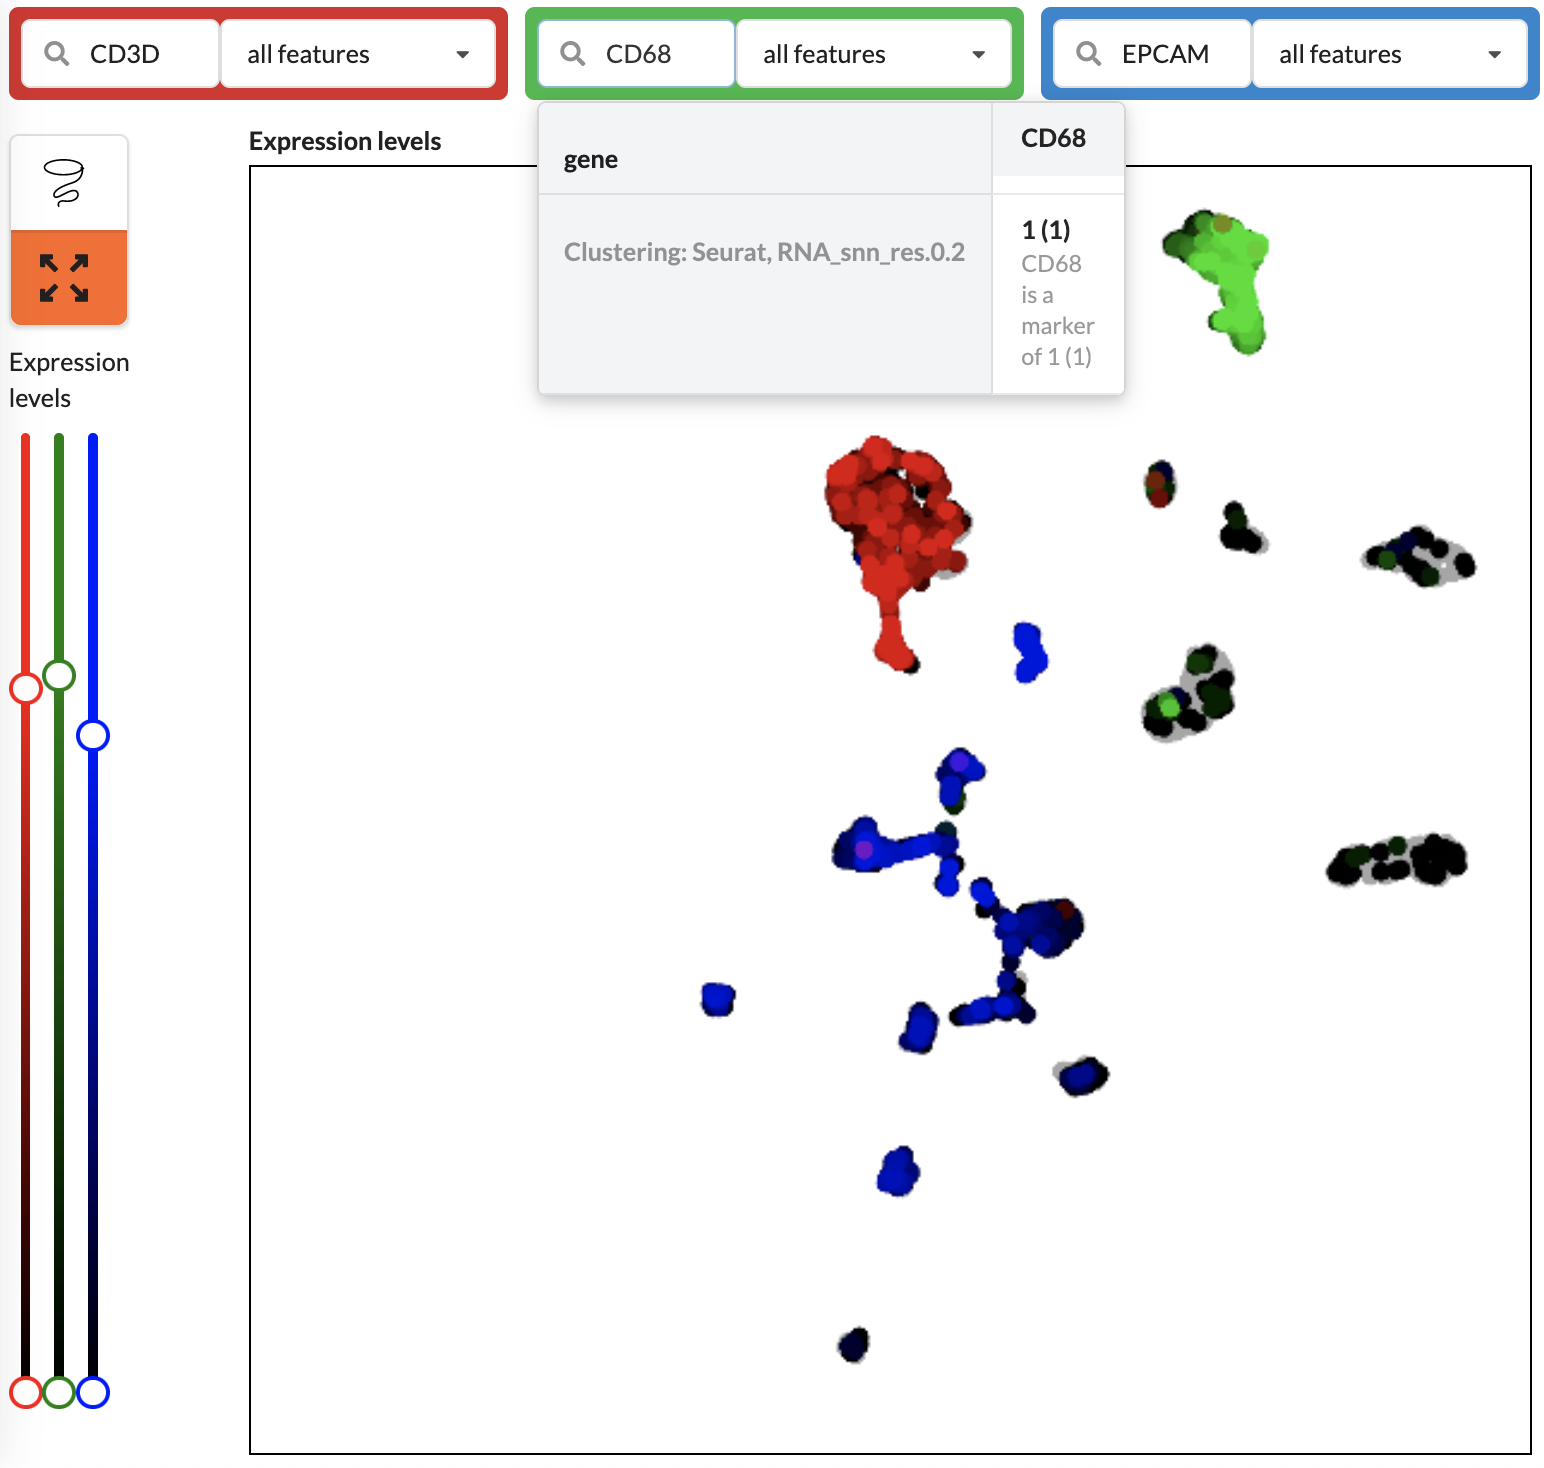

You can also show the annotations:

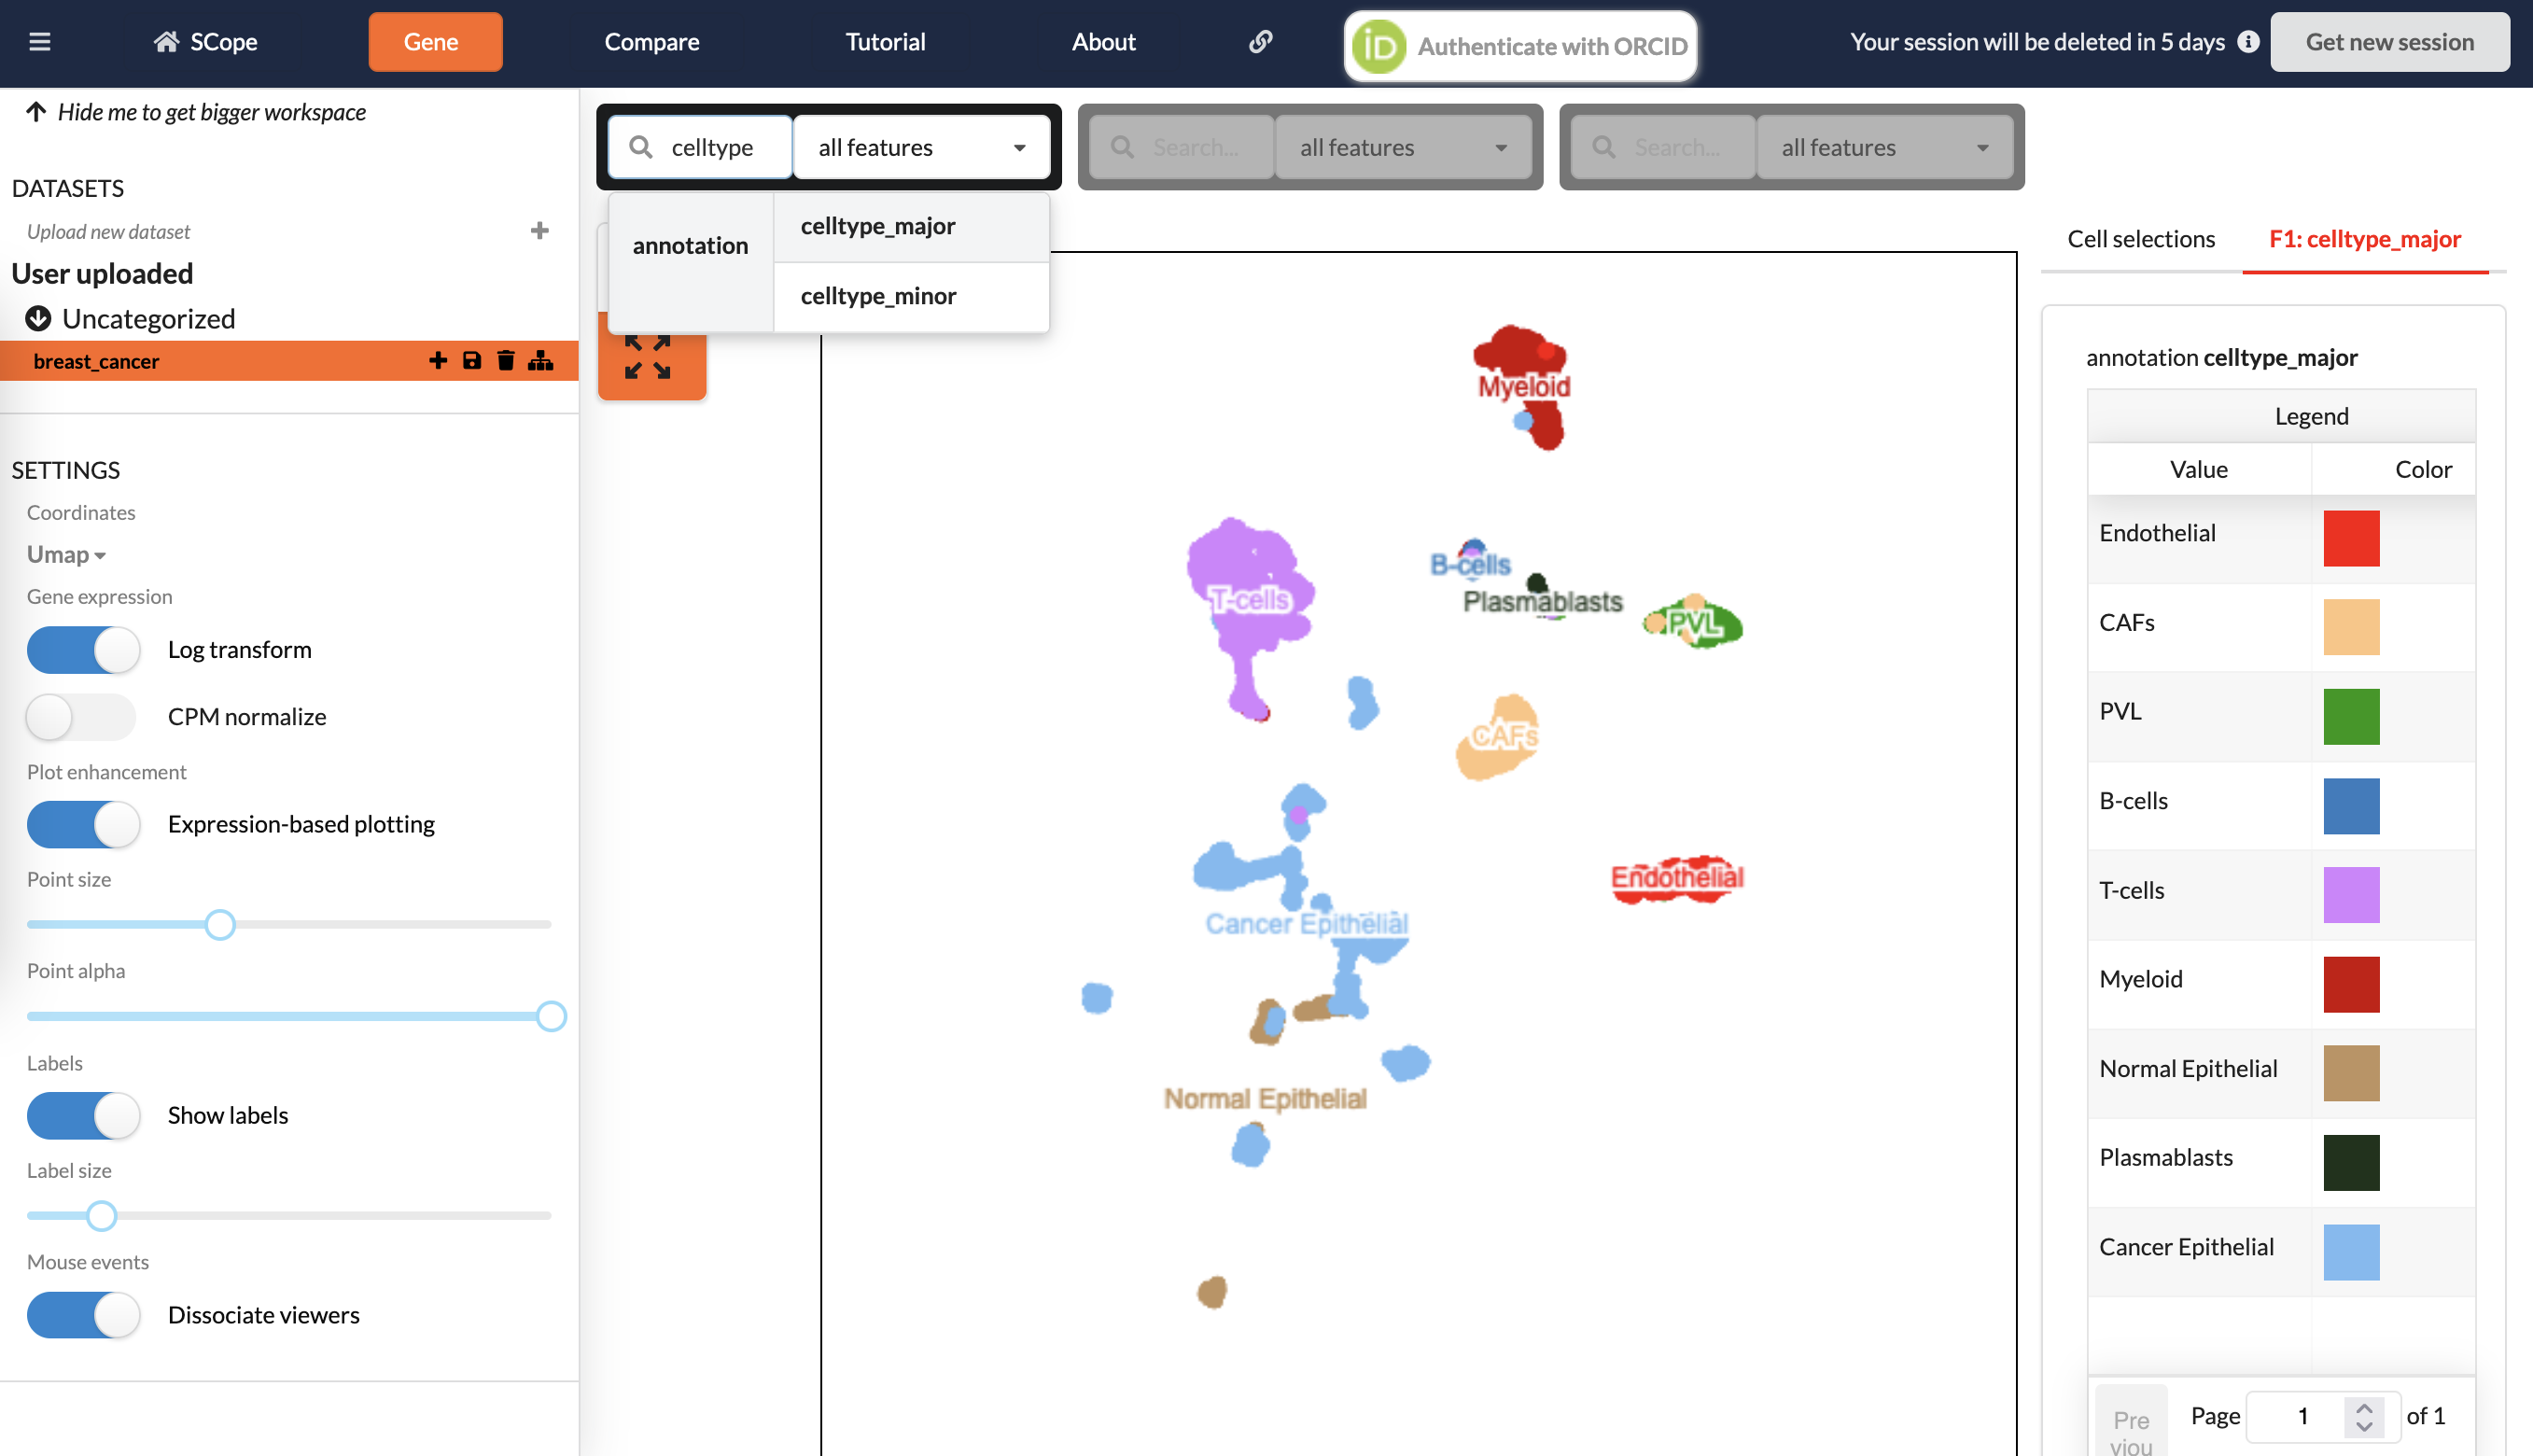

And many more: annotate the clusters, export selections of cells, compare gene expression between categories...

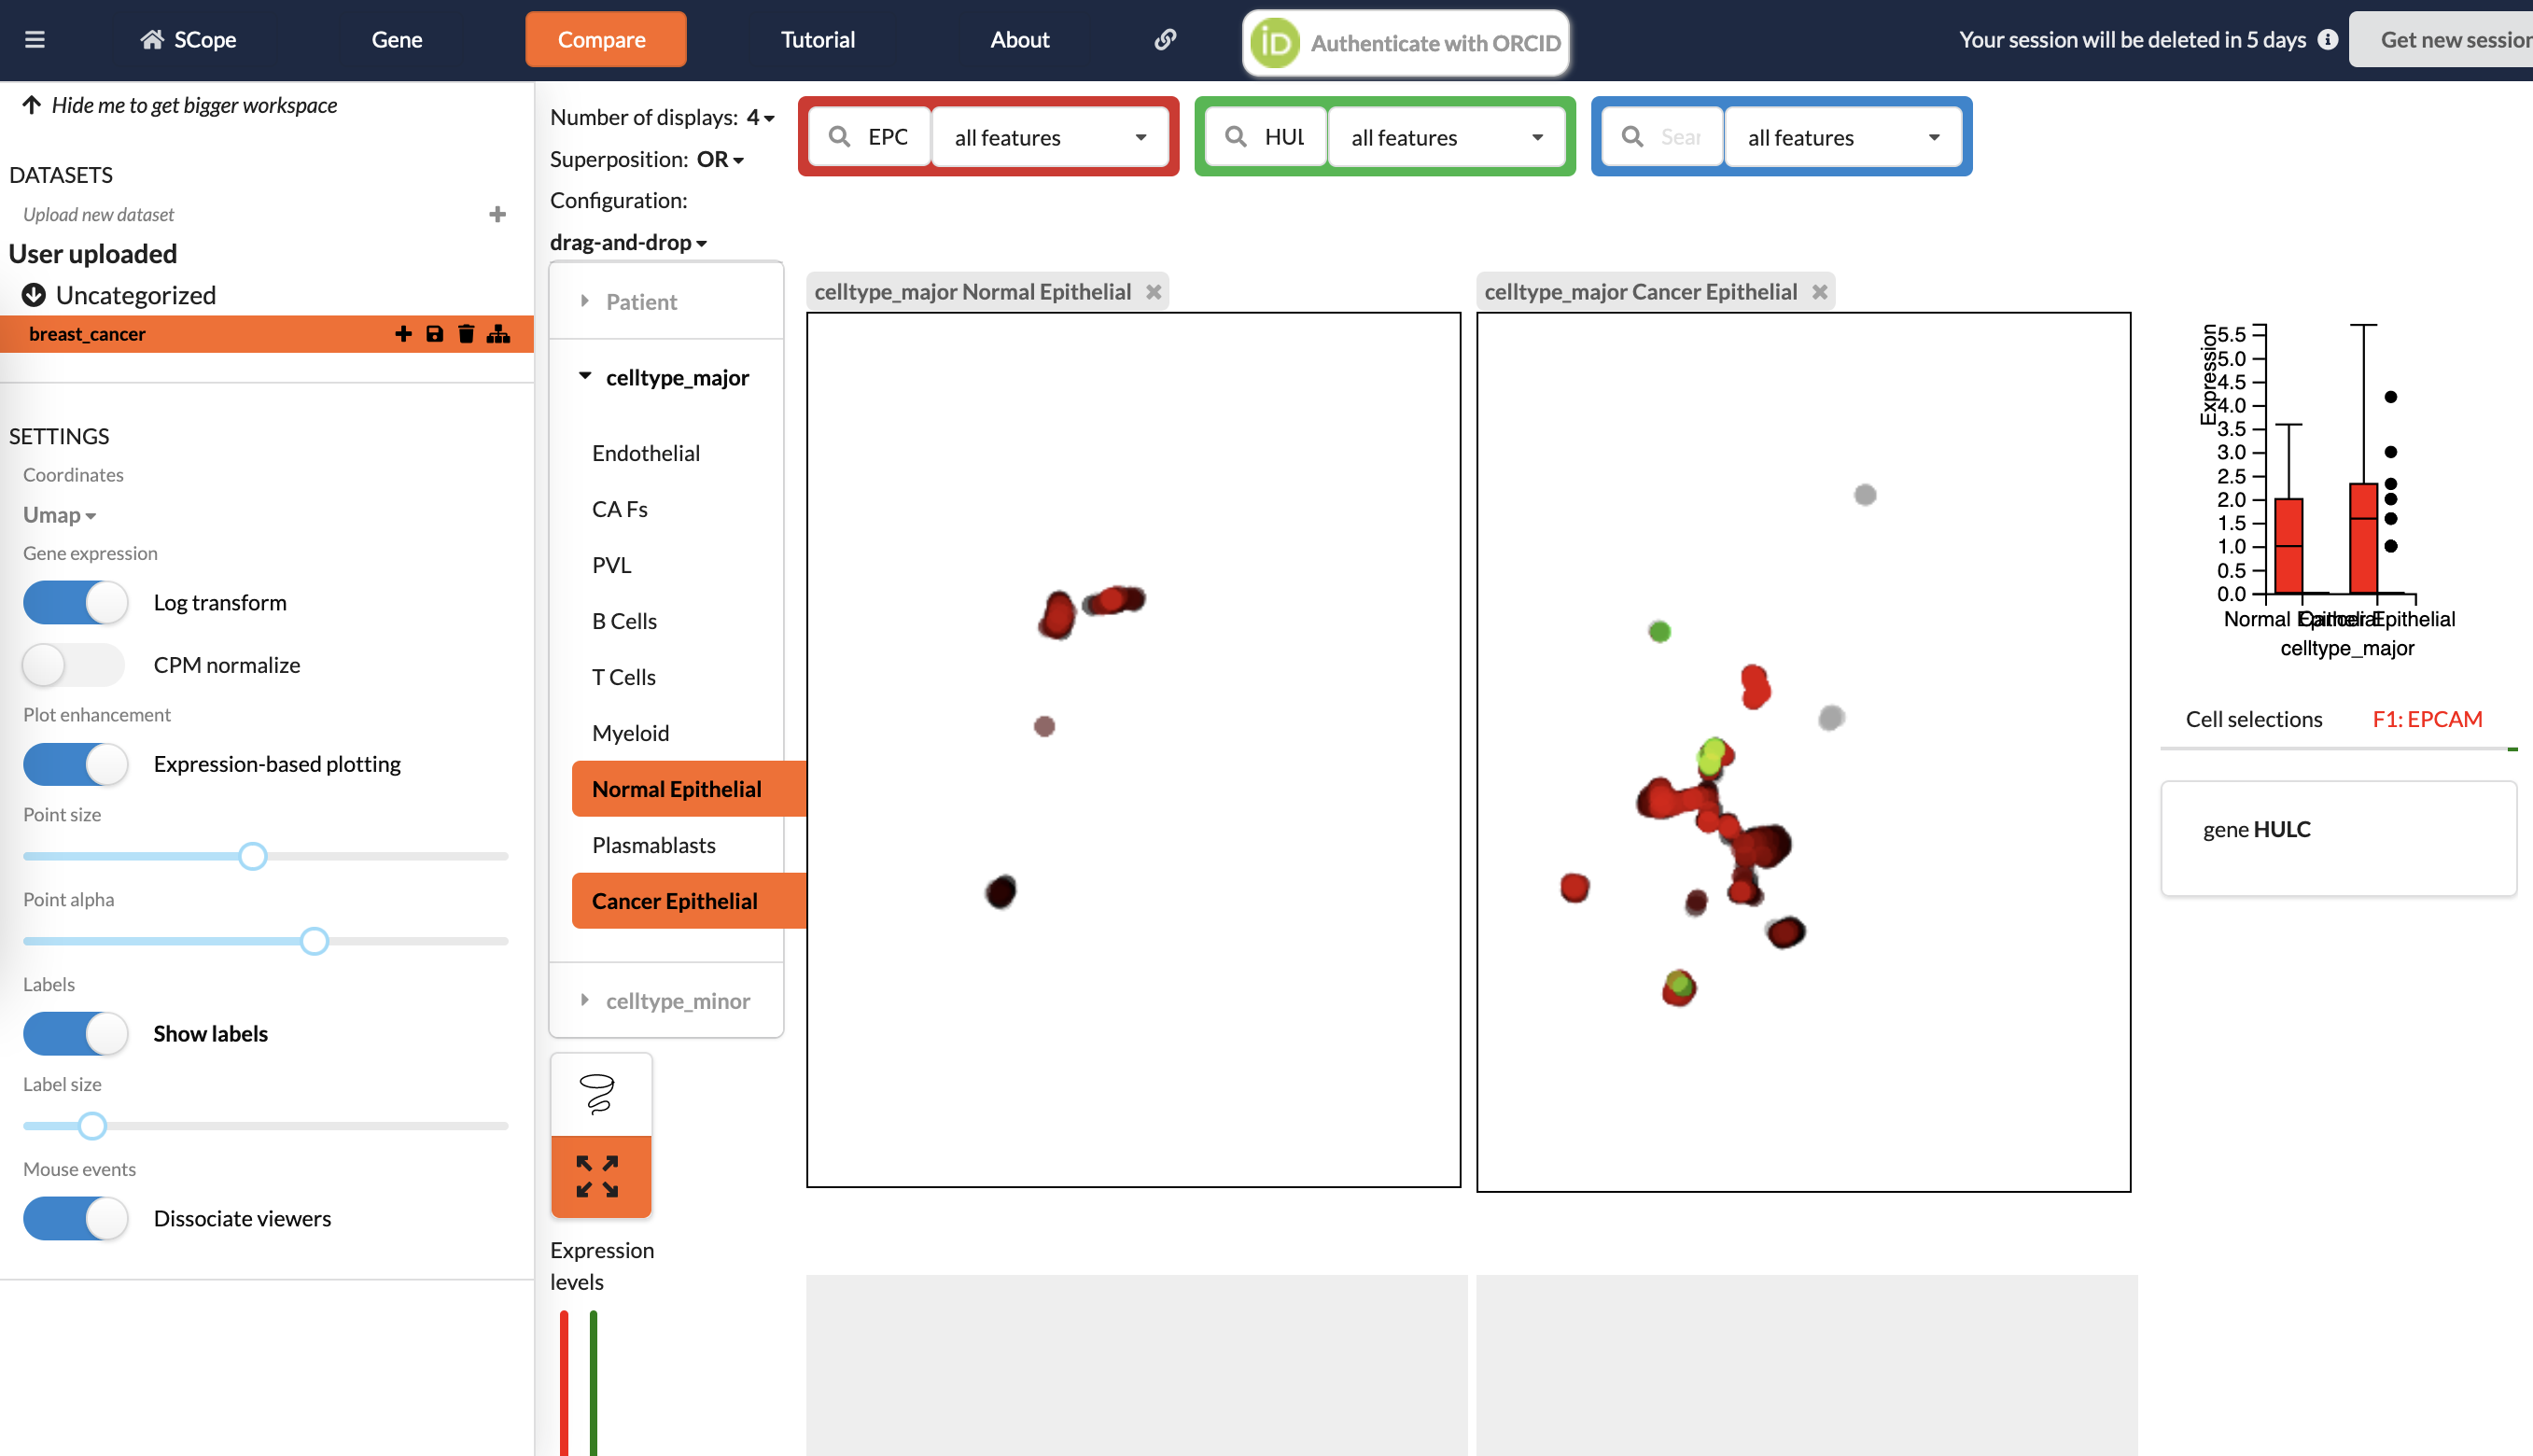

### And before you close your notebook...

If you want to exchange code with others or be able to reproduce your own results, it is a good idea to document the versions of R, the packages you have been using and some system properties

In [ ]:
sessionInfo()